## Импортируем на все деньги

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
dataset = pd.read_csv('dataset.csv')
dataset.shape

(7043, 21)

## Смотрим глазами на данные

Что понятно:
1) Каждая строчка - клиент с какими-то признаками (20 столбцов)
2) Целевая переменная - churn (ушел клиент или нет)

In [3]:
dataset.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
dataset['TotalCharges'] = dataset["TotalCharges"].replace(" ",np.nan)
#Дропаем строки с пропущенными значениями TotalCharges
dataset = dataset[dataset["TotalCharges"].notnull()]
dataset = dataset.reset_index()[dataset.columns]

#переведем в вещественные и целые числа
dataset["TotalCharges"] = dataset["TotalCharges"].astype(float)
dataset["MonthlyCharges"] = dataset["MonthlyCharges"].astype(float)
dataset["tenure"] = dataset["tenure"].astype(int)

#а здесь наоборот переводим в категориальную переменную (да/нет)
dataset["SeniorCitizen"] = dataset["SeniorCitizen"].replace({1:"Yes",0:"No"})

#разделяем колонки на два типа (категориальные и вещественные). Зависимую переменную преобразуем потом
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
categorical_cols = list(set(dataset.columns.values.tolist()) - set(numeric_cols) - set(['Churn','customerID']))
print(categorical_cols)

['SeniorCitizen', 'DeviceProtection', 'OnlineBackup', 'MultipleLines', 'OnlineSecurity', 'StreamingTV', 'Contract', 'StreamingMovies', 'PhoneService', 'PaperlessBilling', 'TechSupport', 'gender', 'Partner', 'Dependents', 'InternetService', 'PaymentMethod']


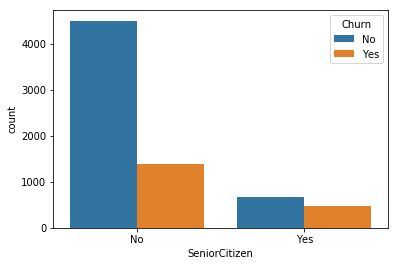

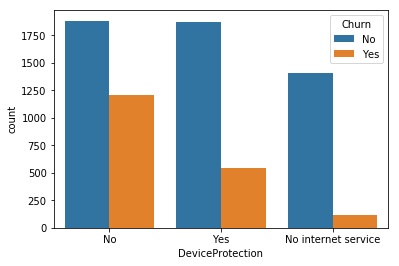

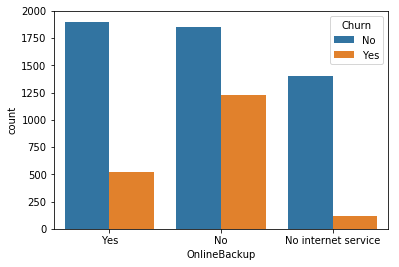

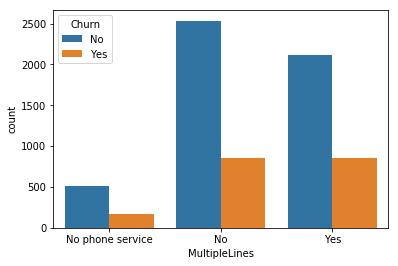

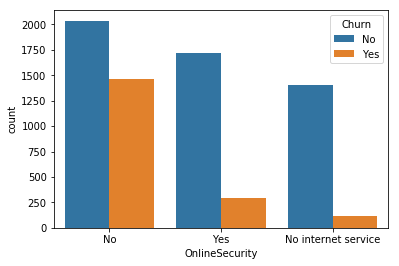

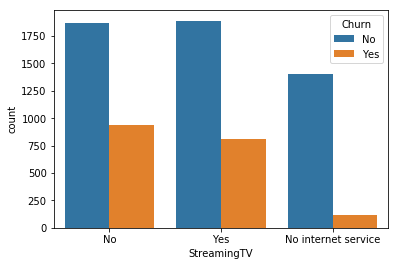

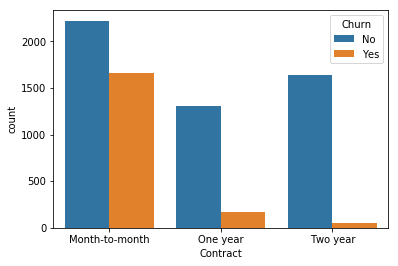

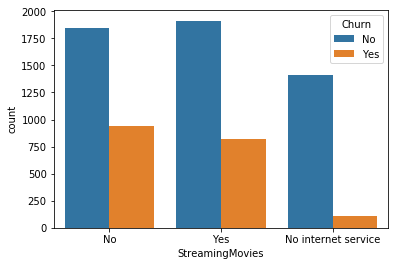

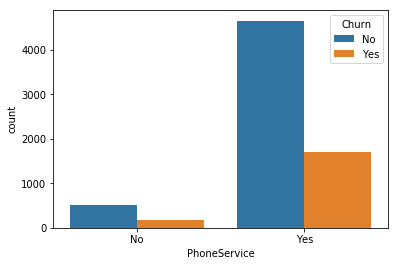

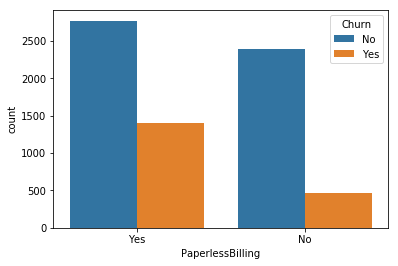

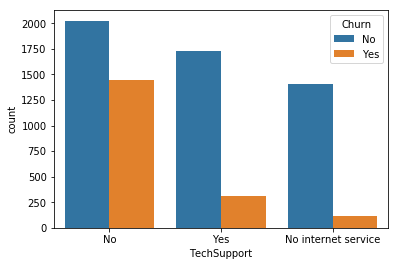

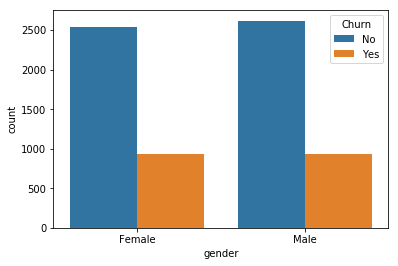

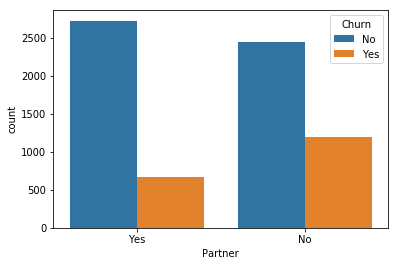

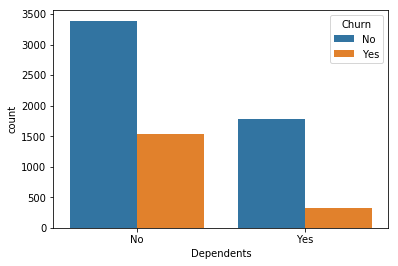

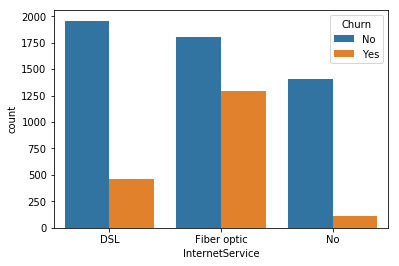

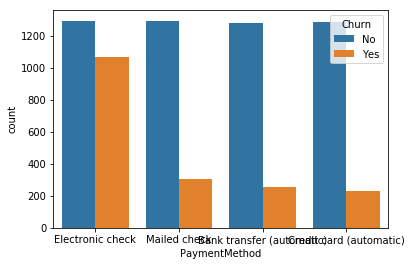

In [5]:
# красиво кучу графиков нарисовать не смог, сорри ¯\_(ツ)_/¯
for var in categorical_cols:
    ax = sns.countplot(x=var,hue="Churn", data=dataset)
    i =+1
    plt.show()

In [6]:
X = dataset.drop('Churn', 1)
Y = dataset['Churn']

X_number = X[numeric_cols]
X_categ = X[categorical_cols]
#на всякий случай все категориальные приведем к строке (вроде они и так строки)
X_categ = X_categ.astype(str)

In [7]:
from sklearn.feature_extraction import DictVectorizer as DV

encoder = DV(sparse = False)
# Преобразуем категориальные переменные к вещественному виду с помощью one hot encoder
X_categ_encoded = encoder.fit_transform(X_categ.T.to_dict().values())
Y_encoded = np.asarray(map((lambda x: 1 if x == 'Yes' else 0),Y))

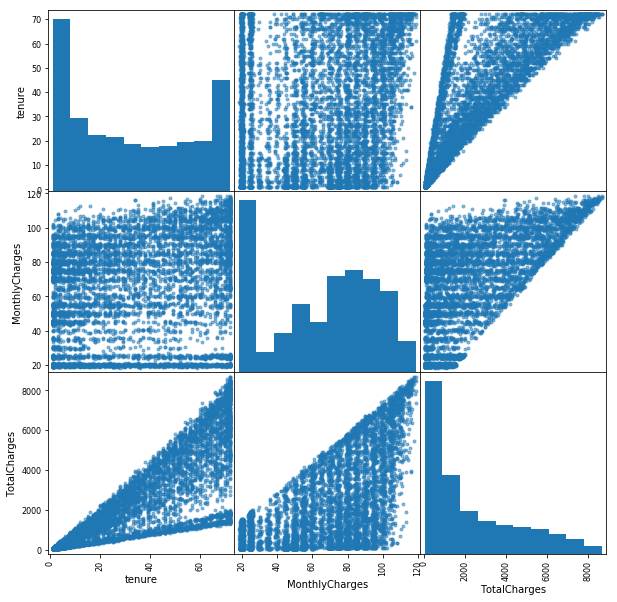

In [8]:
# посмотрим глазами на вещественные признаки. Видно что tenure*monthly_charges дают TotalCharges. 
pd.scatter_matrix(dataset, alpha=0.5, figsize=(10, 10))
plt.show()

In [9]:
from sklearn.preprocessing import StandardScaler

#нормализуем вещественные признаки
scaler = StandardScaler()
scaler.fit(X_number)
X_number_scaled = scaler.transform(X_number)

In [10]:
from sklearn.preprocessing import PolynomialFeatures

# и создадим больше дополнительных фичей
transform = PolynomialFeatures(3)
X_number_scaled_transformed = transform.fit_transform(X_number_scaled)
scaler.fit(X_number_scaled_transformed)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [11]:
#теперь можно сконкатенировать по горизонтали категориальные и вещественные фичи и получить окончательный датасет
X_finish = np.hstack ((X_number_scaled, X_categ_encoded))
X_finish_transformed = np.hstack ((X_number_scaled_transformed, X_categ_encoded))

В качестве метрики будем использовать площадь под AUC кривой (чтобы можно было сравнить разные алгоритмы между собой)

## Для начала попробую построить логистическую регрессию

Для этого нужно:
а) Преобразовать категориальные признаки в вещественные числа
б) Заполнить пропуски (если есть)
в) Отмасштабировать 
г) Сбалансировать выборку
д) Сгенерировать новых фичей (квадраты и линейные комбинации других фичей)
е) Отобрать признаки с помощью L1 регуляризации
ж) Запустить обучение с подбором гиперпараметров

In [16]:
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve

# Функции для обучения 
def learning_model(X, Y, clf, param_grid, scoring):
    # Разделим выборки на test, train
    (X_train, 
     X_test, 
     y_train, y_test) = train_test_split(X, Y, 
                                     test_size=0.2, 
                                     random_state=0)
    # Зададим classifier и сетку параметров
    gridCV = GridSearchCV(clf, param_grid, scoring = scoring, cv = 3)
    # Обучим по сетке
    gridCV.fit(X_train, y_train)
    # Получим предсказания алгоритма
    predictions = gridCV.predict_proba(X_test)[:,1]
    # Получим значения fpr и tpr для roc_curve
    fpr,tpr,thresholds = roc_curve(y_test,predictions)

    fig, ax = plt.subplots()
    ax.plot(fpr, tpr)
    ax.set(xlabel='FPR', ylabel='TPR', title='ROC-CURVE')
    ax.grid()
    plt.show()

    print roc_auc_score(y_test, predictions)
    print gridCV.best_score_
    print gridCV.best_estimator_

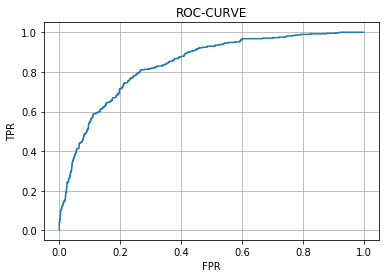

0.837997556276
0.846768727273
LogisticRegression(C=5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [17]:
# Зададим сетку параметров для модели
param_grid_logreg = {'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 15, 20], 'class_weight':['balanced', None],'penalty':['l1','l2'] }
clf_log = LogisticRegression()
# Обучим модель на данных и классификатора выше
learning_model(X_finish, Y_encoded, clf_log, param_grid_logreg, scoring = 'roc_auc')

# Попробуем запустить случайный лес и градиентный бустинг

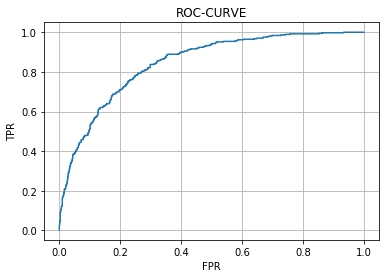

0.844313120395
0.843704
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=24,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)


In [19]:
from sklearn import ensemble 

param_grid_rf = {'n_estimators': [1] + range(10, 55, 5), 'min_samples_split': range(2, 25, 2)}
# Зададим classifier и сетку параметров
estimator_rf = ensemble.RandomForestClassifier(random_state=0)
# Обучим модель на данных и классификатора выше
learning_model(X_finish, Y_encoded, estimator_rf, param_grid_rf, scoring = 'roc_auc')

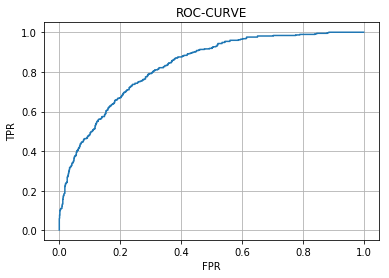

0.830340032687
0.830376
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=10, min_child_weight=6, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


In [23]:
import xgboost as xgb

param_grid_boosting = {"max_depth": [10,30,50],
              "min_child_weight" : [1,3,6],
              "n_estimators": [200],
              "learning_rate": [0.05, 0.1,0.16],}
estimator_boosting = xgb.XGBClassifier()

# Обучим модель на данных и классификатора выше
learning_model(X_finish, Y_encoded, estimator_boosting, param_grid_boosting, scoring = 'roc_auc')